# Style transfer using GAN
This notebook will be used to prepare the capstone project 'Style transfer using GAN'

<b> Problem Statement:

Misdiagnosis in the medical field is a very serious issue but it’s also uncomfortably common to occur. Imaging procedures in the medical field requires an expert radiologist’s opinion since interpreting them is not a simple binary process ( Normal or Abnormal). Even so, one radiologist may see something that another does not. This can lead to conflicting reports and make it difficult to effectively recommend treatment options to the patient.

One of the complicated tasks in medical imaging is to diagnose MRI(Magnetic Resonance Imaging). Sometimes to interpret the scan, the radiologist needs different variations of the imaging which can drastically enhance the accuracy of diagnosis by providing practitioners with a more comprehensive understanding. But to have access to different imaging is difficult and expensive. 

This project, using deep learning (Generative Adversial Networks),aims to achieve conversion of images from Tr1 weights to images of Tr2 weights, so that it can help radiologist for a faster and better diagnosis view.

## Import Libraries

<b> Ignore warnings when importing tensorflow libararies and gast warnings

In [1]:
import warnings 
warnings.filterwarnings('ignore')

<b> Import all the required libraries

In [2]:
import pandas as pd
import cv2
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import numpy as np
from tensorflow import keras

import glob

import re

from sklearn.model_selection import train_test_split

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



<b> Set parameters and variables for initialization

In [3]:
tf.enable_eager_execution()
np.random.seed(100)

<b> BATCH_SIZE=1 gave better image conversion than using batch size of 10/5. so using batch size of 1.

In [4]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
# image size (256,256)
IMG_WIDTH = 256
IMG_HEIGHT = 256
AUTOTUNE = tf.data.experimental.AUTOTUNE


## Data understanding
Import the images & create two seperate datasets. The input shape for image should be (256, 256)


<b> Import images of Tr1 and Tr2 and resize them to (256,256).
    <br>"_parse_function" will load the image and resizes it specified size. <br>It will be called internally by from_tensor_slices.map() function call

In [5]:
def _parse_function(filename):
    # Load image from png files provided
    image_string = tf.read_file(filename)
    image_decoded = tf.image.decode_png(image_string, channels=1)
    image = tf.cast(image_decoded, tf.float32)
    # Resize image to specified size
    image = tf.image.resize(image, [IMG_WIDTH, IMG_HEIGHT],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image

<b> Load list of files and split them so that test data will not be used for training. Since number of images are less, here 10% of images are taken as Test data.
    1. zip both Tr1 and Tr2 file path
    2. split the set so that 10% of list is taken as test set
    3. extract both test_tr1, test_tr2, train_tr1,train_tr2 images

In [6]:
listi_tr1=glob.glob("./dataset/dataset/Tr1/TrainT1/*.png")
listi_tr2=glob.glob("./dataset/dataset/Tr2/TrainT2/*.png")

listi_train,listi_test=train_test_split(list(zip(listi_tr1,listi_tr2)),test_size=0.1)

In [7]:
train_tr1_listi=[it[0] for it in listi_train]
train_tr2_listi=[it[1] for it in listi_train]
test_tr1_listi=[it[0] for it in listi_test]
test_tr2_listi=[it[1] for it in listi_test]

<b> load and process image data using '_parse_function'

In [8]:
tr1 =(tf.data.Dataset.from_tensor_slices((train_tr1_listi))).map(_parse_function)
test_tr1 =(tf.data.Dataset.from_tensor_slices((test_tr1_listi))).map(_parse_function)

In [9]:
tr2 = tf.data.Dataset.from_tensor_slices((train_tr2_listi)).map(_parse_function)
test_tr2 = tf.data.Dataset.from_tensor_slices((test_tr2_listi)).map(_parse_function)

## Image Processing 
1.Create a function to process your images with normalisation

2.Apply the function to both the datasets 

3.Visualise the MRI images after processing




<b> Preprocess data:<br>
    &emsp;Random mirroring<br>
    &emsp;Normalize data

In [10]:
# normalizing the images to [-1, 1]
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

In [11]:
# Preprocess images so that they are suitable for analysis
def preprocess_image_train(image):
    image = tf.image.random_flip_left_right(image)
    image = normalize(image)
    return image

<b> processing both classes of MRI images<br><br>

We dont need pair wise translation of images with cycle GAN, hence doing ramdom shuffling. Here input and expected images are not matched, where model is trained to learn about patterns of weight conversion

In [12]:
tr1 = tr1.map(preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
tr2 = tr2.map(preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_tr1 = test_tr1.map(preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_tr2 = test_tr2.map(preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Visualize a sample data

In [13]:
sample_tr1 = next(iter(tr1))
sample_tr2 = next(iter(tr2))

<b> Tr1

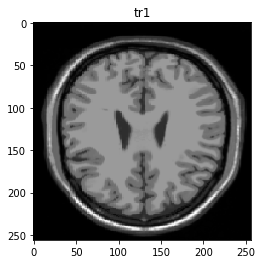

In [14]:
plt.title('tr1')
plt.imshow(sample_tr1[0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')

<b> Tr2

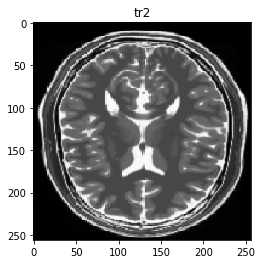

In [15]:
plt.title('tr2')
plt.imshow(sample_tr2[0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')

## Model Building & Training
The architecture of generator is a modified U-Net.

1.Create your Generator & Discriminator

2.Define the loss functions

3.Create the train_step function

### Define Instance normalization and Upsample/Downsample methods

In [16]:
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)
    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    if apply_norm:
        result.add(InstanceNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    result.add(InstanceNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

### Define Generator

In [17]:
def unet_generator():
    ##Configure downsample and upsample stack layers in Generator Neural network
    down_stack = [downsample(16,(5,5)),downsample(32,(5,5)),downsample(64,(5,5))]
    up_stack = [upsample(64,(5,5)),upsample(32,(5,5)),upsample(16,(5,5))]
        
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same', kernel_initializer=initializer,
                                           activation='tanh') # (bs, 256, 256, 1)
    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[None, None, 1])
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

### Instantiate generators

In [18]:
generator_g = unet_generator()
generator_f = unet_generator()

### Define discriminator

In [19]:
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[None, None, 1], name='input_image')
    x = inp
    down1 = downsample(16,(5,5))(x)#downsample X
    down2 = downsample(32,(5,5))(down1)#downsample down1
    down3 = downsample(64,(5,5))(down2)#downsample down2
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) 
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) #using 512 filters as given since results look fine.
    norm1 = InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1) #using leaky RELU for this analysis
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) 
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)
    return keras.Model(inputs= inp, outputs= last)#model using input & output layer

### Instantiate discriminators

In [20]:
discriminator_x = discriminator()
discriminator_y = discriminator()

## Visualize a sample image produced from generator

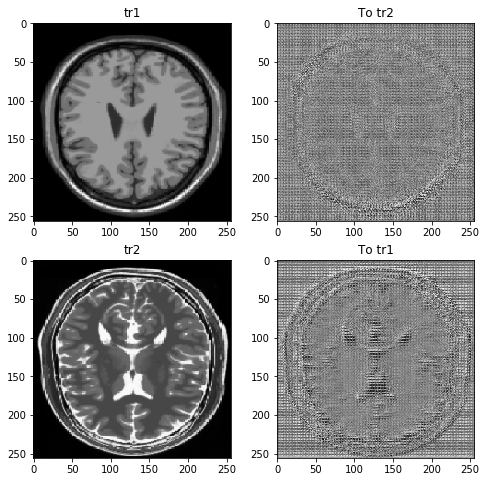

In [21]:
to_tr2 = generator_g(sample_tr1)
to_tr1 = generator_f(sample_tr2)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_tr1, to_tr2, sample_tr2, to_tr1]
title = ['tr1', 'To tr2', 'tr2', 'To tr1']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
    else:
        plt.imshow(imgs[i][0].numpy()[:, :, 0] * 0.5 * contrast + 0.5, cmap='gray')
plt.show()

## Define Loss functions and Optimizer

In [22]:
LAMBDA = 5

In [23]:
# Using binarycross entropy loss
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [24]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

In [25]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

Use Cycle consistency loss to check the result to be close to input. Result shouldnt deviate from input sample.
<br> If X is passed to generator G and we get image Y<br>
Now if image Y is passed to F and we get X1 <br> Accordingly X1 should be same as X ie., mean absolute error between real image and cycled image should be less

In [26]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

Identity loss is used to prevent unnecessary drastic change of Y when passed to genertor g. <br> If Y is passed to generator g , the resultant output should be close to input image Y or should be same as Y.

In [27]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

<b> Using Adam optimizer with below parameters configured

In [28]:
generator_g_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.3)
generator_f_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.3)

discriminator_x_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.3)
discriminator_y_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.3)

## configure number of Epochs and Checkpoint

In [29]:
EPOCHS = 200 #configure epochs for sufficient training

In [30]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=EPOCHS)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

## Model Training

function to get predictions from model for showing results on how the training is progressing and also on visualizing test results

In [31]:
def generate_images(model, test_input, expected_output):
    prediction = model(test_input)
    plt.figure(figsize=(10, 10))
    display_list = [test_input[0], prediction[0], expected_output[0]]
    title = ['Input Image', 'Predicted Image', 'sample Image from Expected dataset']
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
        plt.axis('off')
    plt.show()

Function to train the model based on imput image samples

In [32]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.
        fake_y = generator_g(real_x, training=True)#generate images using Generator_g on real_x
        cycled_x = generator_f(fake_y, training=True)#generate images susiing Generator_f on fake_y
        
        fake_x = generator_f(real_y, training=True)#generate images using Generator_f on real_y
        cycled_y = generator_g(fake_x, training=True)#generate images using Generator_g on fake_x
        
        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)#generate images using Generator_f on real_x
        same_y = generator_g(real_y, training=True)#generate images using Generator_g on real_y
        
        disc_real_x = discriminator_x(real_x, training=True)#discriminate images using Discriminator_x on real_x
        disc_real_y = discriminator_y(real_y, training=True)#discriminate images using Discriminator_y on real_y
        
        disc_fake_x =  discriminator_x(fake_x, training=True)#discriminate images using Discriminator_x on fake_x
        disc_fake_y = discriminator_y(fake_y, training=True)#discriminate images using Discriminator_y on fake_y
        
        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)# calculate the generator_loss for disc_fake_
        gen_f_loss = generator_loss(disc_fake_x)# calculate the generator_loss for disc_fake_X 
        
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)#calculate the total cycle loss
        
        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
        
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)# calculate the discriminator_loss for disc_fake_x wrt disc_real_x
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)# calculate the discriminator_loss foor disc_fake_y wrt disc_real_y
        
    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
    
    discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
    
    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))


Train GAN model for range of EPOCHS and visualize results to check on training progress

In [ ]:
for epoch in range(EPOCHS):
    for image_x, image_y in tf.data.Dataset.zip((tr1, tr2)):
        train_step(image_x, image_y)
    generate_images(generator_g, sample_tr1, sample_tr2)
    ckpt_save_path = ckpt_manager.save()
    print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)

<b> Model is able to learn the patterns for converting images from Tr1 to Tr2 over increasing number of epochs and produced stable results for large number of epochs, which means model is able to learn patters for conversion of weights consistently

## Evaluation on test data

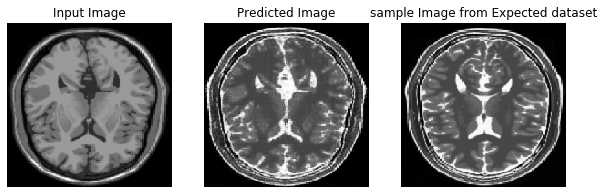

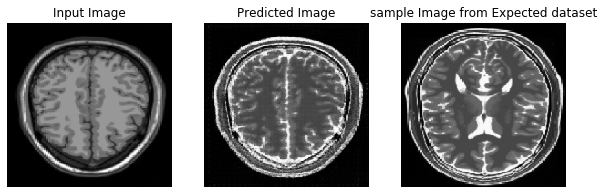

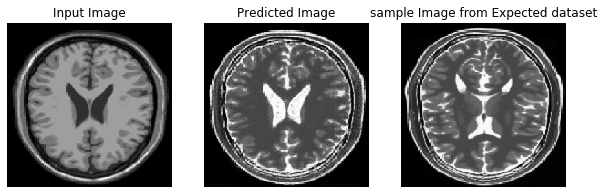

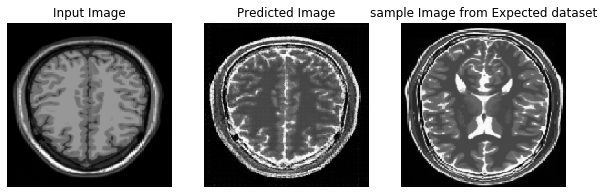

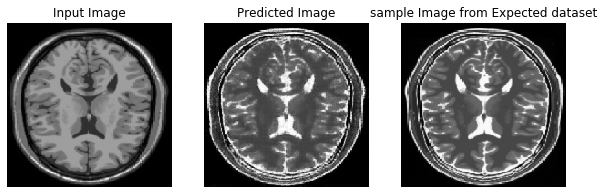

In [34]:
# Run the trained model on the test dataset
for inp in test_tr1.take(5):
    generate_images(generator_g, inp, sample_tr2)

<b> Because of unpairing and randomly flipping of images, images on predicted and expected are not identical. However we can see that model is able to transform input image in Tr1 to Tr2, by comparing with random sample image in Tr2

## Analysis of results

Results from analysis shows that this project shall help in conversion from Tr1 to Tr2 weights of MRI scan thereby helping radiologist to analyze ECG's for faster and better diagnosis.

From analysis we see that input image and expected image are not one to one mapped images i.e., they are not paired images, but model is able to extract the pattern to convert images from one Weight to another weight.